In [10]:
import pandas as pd

In [11]:
df = pd.read_csv("../processed.csv")

In [12]:
# We can assume no change
df['comments_per_likes_weekly_change'].replace([float('inf'), float('-inf')], 0, inplace=True)

C:\Users\JJ\AppData\Local\Temp\ipykernel_24940\2035501673.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['comments_per_likes_weekly_change'].replace([float('inf'), float('-inf')], 0, inplace=True)


In [13]:
def calculate_stability_scores(group):
    # Convert 'date' to datetime if not already
    group['date'] = pd.to_datetime(group['date'])
    # Sort by date to ensure the order is correct for rolling calculations
    group = group.sort_values('date')
    
    # Initialize rolling window size (e.g., 5 weeks)
    window_size = 5
    
    # Calculate rolling standard deviations and max/min within the rolling window
    rolling_stds = group[['likes_per_content', 'comments_per_likes', 'followers_weekly_change', 'Close_price_weekly_change']].rolling(window=window_size, min_periods=1).std()
    rolling_maxs = group[['likes_per_content', 'comments_per_likes', 'followers_weekly_change', 'Close_price_weekly_change']].rolling(window=window_size, min_periods=1).max()
    rolling_mins = group[['likes_per_content', 'comments_per_likes', 'followers_weekly_change', 'Close_price_weekly_change']].rolling(window=window_size, min_periods=1).min()

    # Calculate moving averages required for MA Convergence Score
    # For example, calculate MA for 2 weeks and 5 weeks
    group['comments_per_likes_ma_2'] = group['comments_per_likes'].rolling(window=2, min_periods=1).mean()
    group['change_followers_ma_2'] = group['followers_weekly_change'].rolling(window=2, min_periods=1).mean()
    group['Close_price_weekly_change_ma_2'] = group['Close_price_weekly_change'].rolling(window=2, min_periods=1).mean()

    group['comments_per_likes_ma_5'] = group['comments_per_likes'].rolling(window=5, min_periods=1).mean()
    group['change_followers_ma_5'] = group['followers_weekly_change'].rolling(window=5, min_periods=1).mean()
    group['Close_price_weekly_change_ma_5'] = group['Close_price_weekly_change'].rolling(window=5, min_periods=1).mean()

    # Calculate consistency and volatility scores
    group['engagement_consistency_score'] = 1 - (rolling_stds[['likes_per_content', 'comments_per_likes']].mean(axis=1) / rolling_maxs[['likes_per_content', 'comments_per_likes']].mean(axis=1))
    group['growth_consistency_score'] = 1 - (rolling_stds['followers_weekly_change'] / rolling_maxs['followers_weekly_change'])
    group['price_volatility_score'] = 1 - (rolling_stds['Close_price_weekly_change'] / rolling_maxs['Close_price_weekly_change'])

    # Calculate MA Convergence Score
    ma_diff = group[['comments_per_likes_ma_2', 'change_followers_ma_2', 'Close_price_weekly_change_ma_2', 'comments_per_likes_ma_5', 'change_followers_ma_5', 'Close_price_weekly_change_ma_5']].iloc[-1].sum()
    group['ma_convergence_score'] = 1 - (abs(group['comments_per_likes_ma_2'] - group['comments_per_likes_ma_5']) +
                                         abs(group['change_followers_ma_2'] - group['change_followers_ma_5']) +
                                         abs(group['Close_price_weekly_change_ma_2'] - group['Close_price_weekly_change_ma_5'])) / (ma_diff if ma_diff != 0 else 1)
    
    # Weights for combining scores
    weights = {'engagement_consistency_score': 0.2, 'growth_consistency_score': 0.2, 'price_volatility_score': 0.3, 'ma_convergence_score': 0.3}
    group['stability_score'] = (group['engagement_consistency_score'] * weights['engagement_consistency_score'] +
                                group['growth_consistency_score'] * weights['growth_consistency_score'] +
                                group['price_volatility_score'] * weights['price_volatility_score'] +
                                group['ma_convergence_score'] * weights['ma_convergence_score'])

    return group

grouped_df = df.groupby('legal_entity').apply(calculate_stability_scores).reset_index(drop=True)
final_scores = grouped_df.groupby('legal_entity')['stability_score'].mean()

# Convert to DataFrame for better visualization and further use
final_scores_df = final_scores.reset_index()
final_scores_df.columns = ['legal_entity', 'Average Stability Score']

final_scores_df = final_scores_df.sort_values('Average Stability Score', ascending=False)
final_scores_df

C:\Users\JJ\AppData\Local\Temp\ipykernel_24940\849034353.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = df.groupby('legal_entity').apply(calculate_stability_scores).reset_index(drop=True)


,legal_entity,Average Stability Score
21,Caleres Inc,4.806212
2,Align Technology,4.497284
5,Anheuser-Busch;Cia Antarctica Paulista-Industr...,3.154313
61,Helen of Troy Ltd,2.885112
103,Sleep Number,2.755581
...,...,...
47,EssilorLuxottica,-inf
98,Seiko Group Corp,-inf
49,Evolus Inc,-inf
96,Sainsburys Supermarket,-inf


# Score Validation
Are the reported scores actually displaying stable companies? Let's check some plots

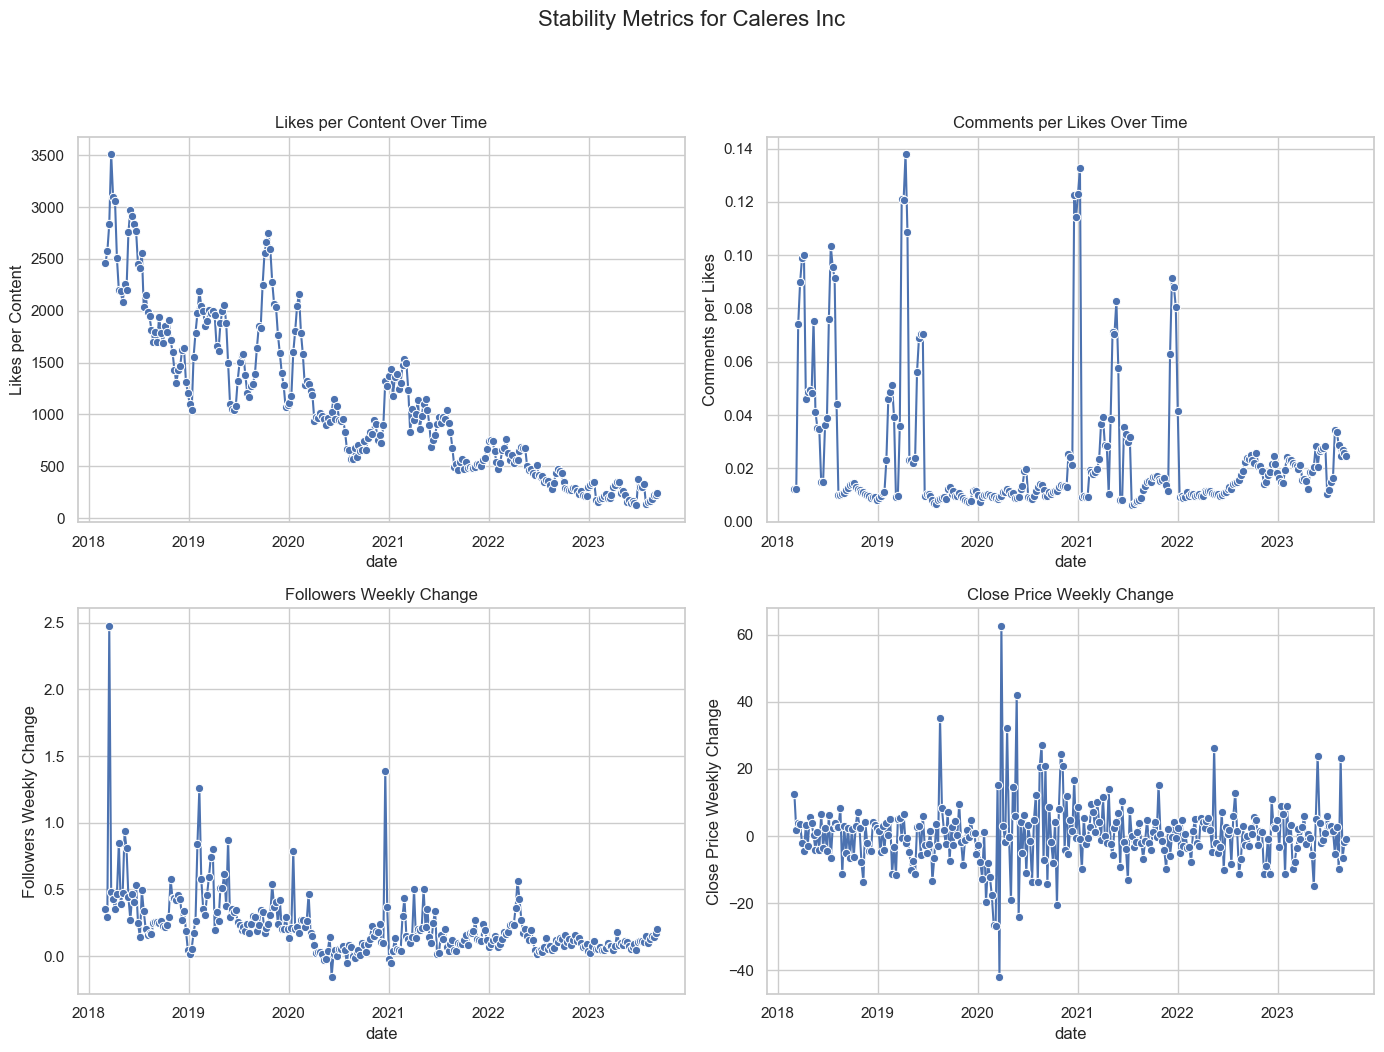

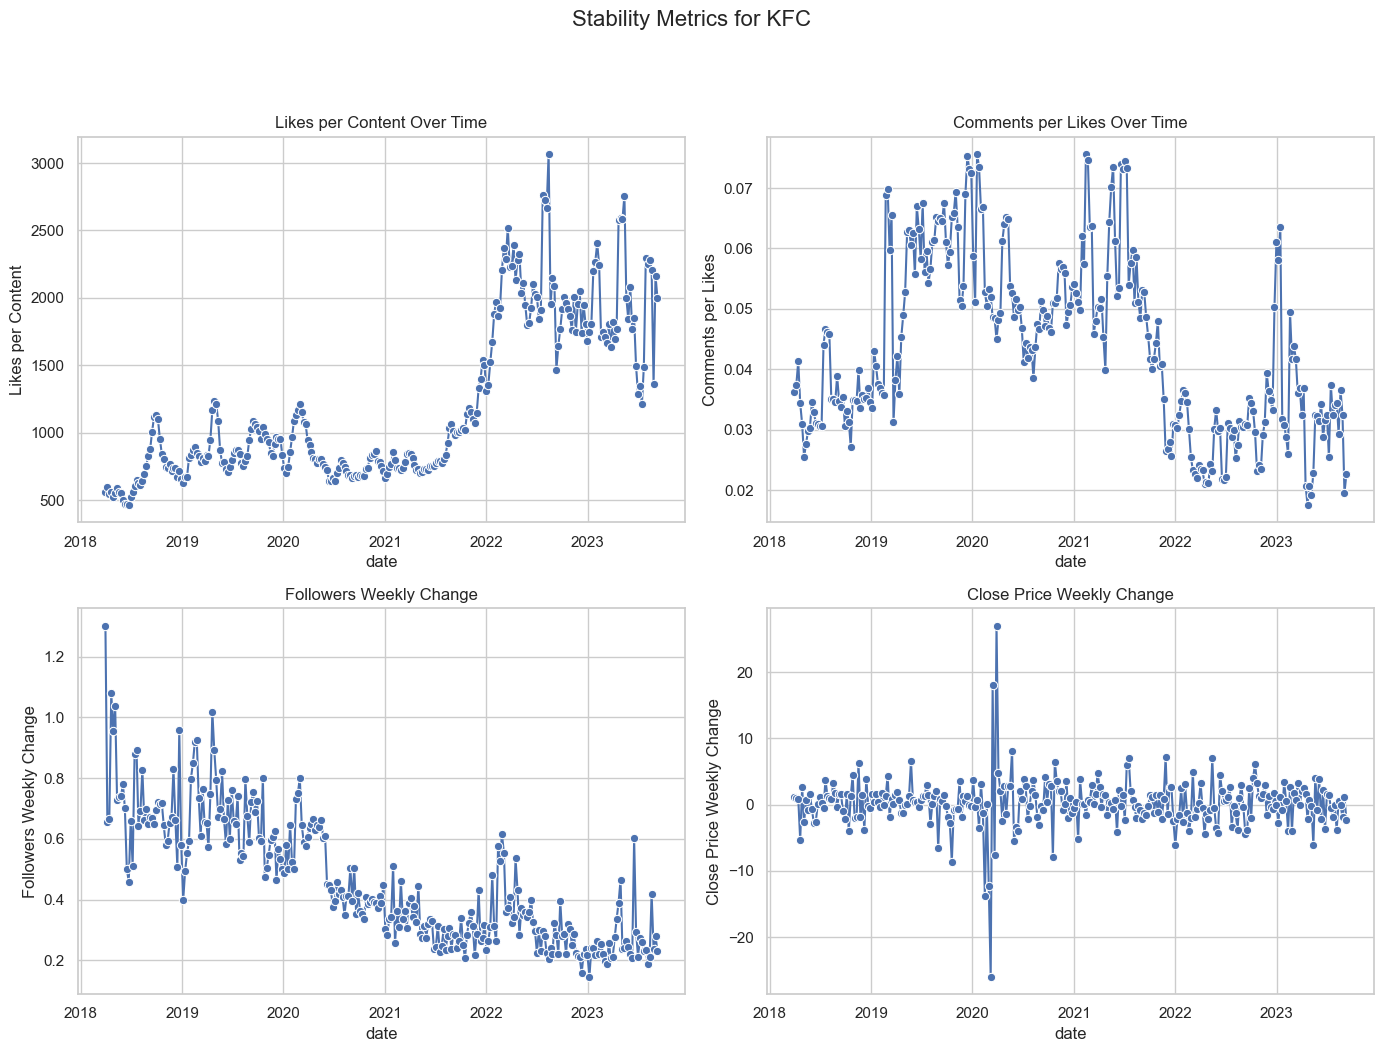

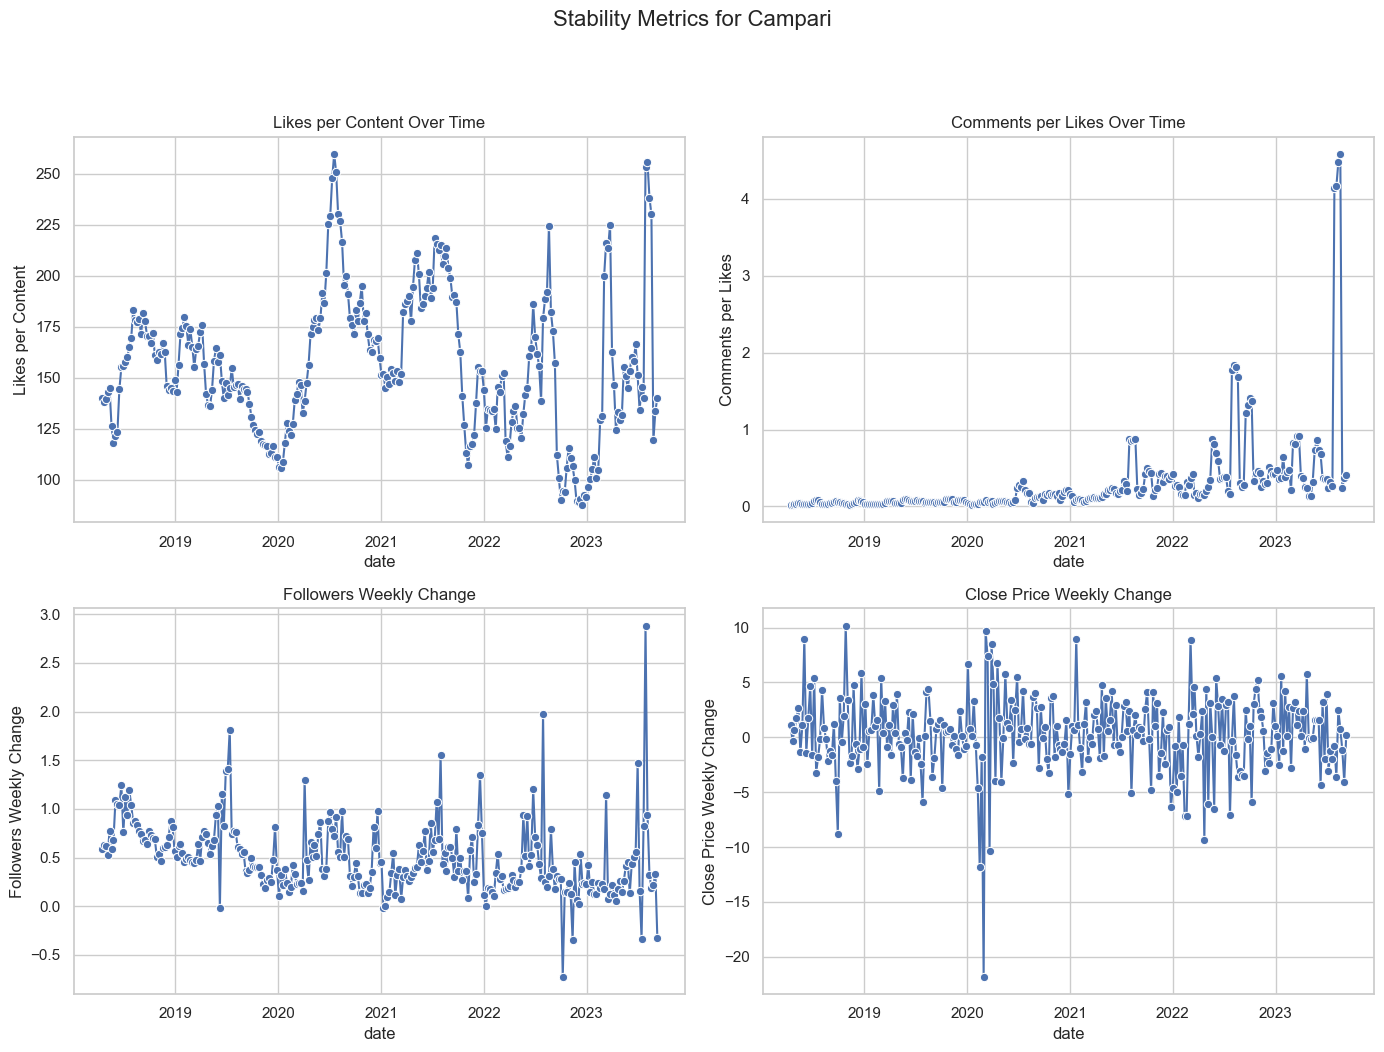

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame containing all the data

# List of legal_entitys you want to analyze
legal_entitys = ['Caleres Inc', 'KFC', 'Campari']  # Replace or add legal_entitys as needed

# Convert 'date' to datetime if not already and sort by 'date'
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Set the style
sns.set(style="whitegrid")

# Loop through each legal_entity
for legal_entity in legal_entitys:
    # Filter data for the current legal_entity
    legal_entity_data = df[df['legal_entity'] == legal_entity]
    
    # Create a figure to hold the subplots for the current legal_entity
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    fig.suptitle(f'Stability Metrics for {legal_entity}', fontsize=16, y=1.05)

    # Plotting Likes per Content
    sns.lineplot(x='date', y='likes_per_content', data=legal_entity_data, ax=axes[0, 0], marker='o')
    axes[0, 0].set_title('Likes per Content Over Time')
    axes[0, 0].set_ylabel('Likes per Content')
    axes[0, 0].set_xlabel('date')

    # Plotting Comments per Likes
    sns.lineplot(x='date', y='comments_per_likes', data=legal_entity_data, ax=axes[0, 1], marker='o')
    axes[0, 1].set_title('Comments per Likes Over Time')
    axes[0, 1].set_ylabel('Comments per Likes')
    axes[0, 1].set_xlabel('date')

    # Plotting Followers Weekly Change
    sns.lineplot(x='date', y='followers_weekly_change', data=legal_entity_data, ax=axes[1, 0], marker='o')
    axes[1, 0].set_title('Followers Weekly Change')
    axes[1, 0].set_ylabel('Followers Weekly Change')
    axes[1, 0].set_xlabel('date')

    # Plotting Close Price Weekly Change
    sns.lineplot(x='date', y='Close_price_weekly_change', data=legal_entity_data, ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('Close Price Weekly Change')
    axes[1, 1].set_ylabel('Close Price Weekly Change')
    axes[1, 1].set_xlabel('date')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


In [17]:
final_scores_df.to_csv("stability_scores.csv", index=False)